In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [4]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm


import pandas as pd
import numpy as np
import scipy

In [5]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = ''  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

ES_BullishCollarBW
ES_BearishCollarBW
ES_CallSpread
ES_PutSpread
ES_ContFut
ZS_BullishCollarBW
ZS_BearishCollarBW
ZS_CallSpread
ZS_PutSpread
ZS_ContFut
CL_BullishCollarBW
CL_BearishCollarBW
CL_CallSpread
CL_PutSpread
CL_ContFut
ZW_BullishCollarBW
ZW_BearishCollarBW
ZW_CallSpread
ZW_PutSpread
ZW_ContFut
ZN_BullishCollarBW
ZN_BearishCollarBW
ZN_CallSpread
ZN_PutSpread
ZN_ContFut
NG_BullishCollarBW
NG_BearishCollarBW
NG_CallSpread
NG_PutSpread
NG_ContFut
ZC_BullishCollarBW
ZC_BearishCollarBW
ZC_CallSpread
ZC_PutSpread
ZC_ContFut


In [6]:
class StrategyRenko_RollingMinMax(StrategyBase):
    name = 'StrategyRenko_RollingMinMax'


    def __init__(self, strategy_context):
        # Initialize parent class
        super().__init__(strategy_context)
   
    def calculate(self, params=None, save_info=False):
    #
    #
    #  Params is a tripple like (50, 10, 15), where:
    #   50 - slow MA period
    #   10 - fast MA period
    #   15 - median period
    #
    #  On every iteration of swarming algorithm, parameter set will be different.
    #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
    #

        if params is None:
            # Return default parameters
            direction, rolling_period = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            direction, rolling_period, rules_index = params

        # Defining EXO price
        px = self.data.exo


        O = L = H = C = px
        atr = ATR(H, L, C, 60)
        
        #rules_list = [px == px.rolling(rolling_period).max(), px == px.rolling(rolling_period).min(), 
        #              px > px.rolling(rolling_period).min() + atr, px < px.rolling(rolling_period).max() - atr]

        if direction == 1:          
            
            rules_list = [px == px.rolling(rolling_period).max(),px == px.rolling(rolling_period).min()
                          , px > px.rolling(rolling_period).min() + atr]
            
            entry_signal = rules_list[rules_index]
            
            entry_rule = (entry_signal == 1) & (entry_signal.shift(1) == 1)
            exit_rule = entry_signal == 0

        elif direction == -1:
            
            rules_list = [px == px.rolling(rolling_period).min(), px == px.rolling(rolling_period).max()
                          , px < px.rolling(rolling_period).max() - atr]
            
            entry_signal = rules_list[rules_index]
            
            entry_rule = (entry_signal == 1) & (entry_signal.shift(1) == 1)
            exit_rule = entry_signal == 0

        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness
        swarm_member_name = self.get_member_name(params)

        #
        # Calculation info
        #
        calc_info = None
        if save_info:
            calc_info = {'trailing_stop': trailing_stop}

        return swarm_member_name, entry_rule, exit_rule, calc_info

## Script settings

In [23]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': StrategyRenko_RollingMinMax,
        'exo_name': 'CL_BearishCollarBW',        # <---- Select and paste EXO name from cell above
        'exo_storage': storage,          
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [1]),
                        
                        OptParam('Rolling_period', 9, 2, 100, 2),
                        OptParamArray('Rules index', np.arange(3)),
            
            ],
    },
    'swarm': {
        'members_count': 2,
        'ranking_class': RankerBestWithCorrel(window_size=-1, correl_threshold=0.5),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [ ]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

### WARNING! Loading swarm from file (don't run next cell if you want new swarm instance)

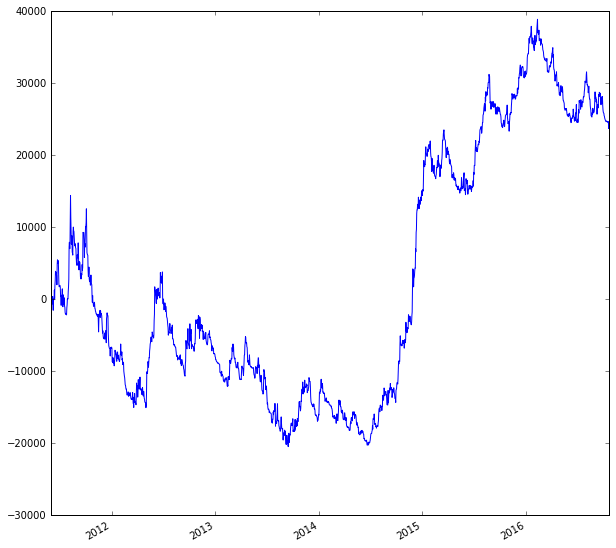

In [16]:
smgr.strategy.data.exo.plot()

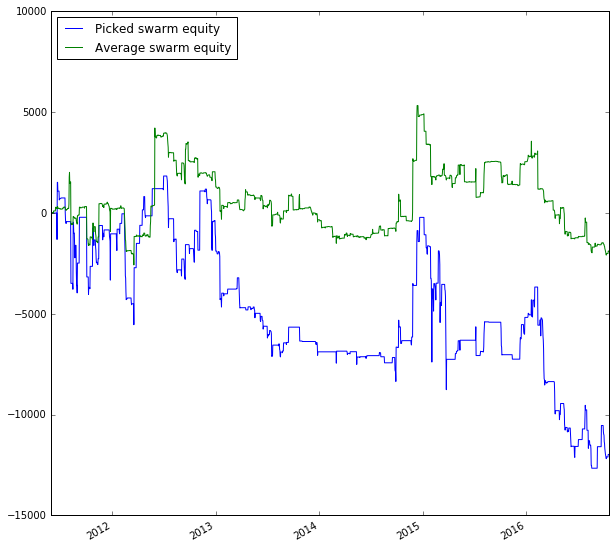

In [17]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

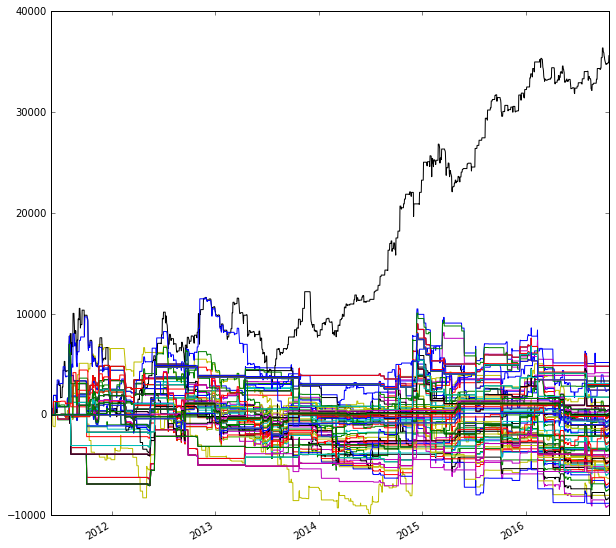

In [18]:
smgr.raw_swarm.plot(legend=False)

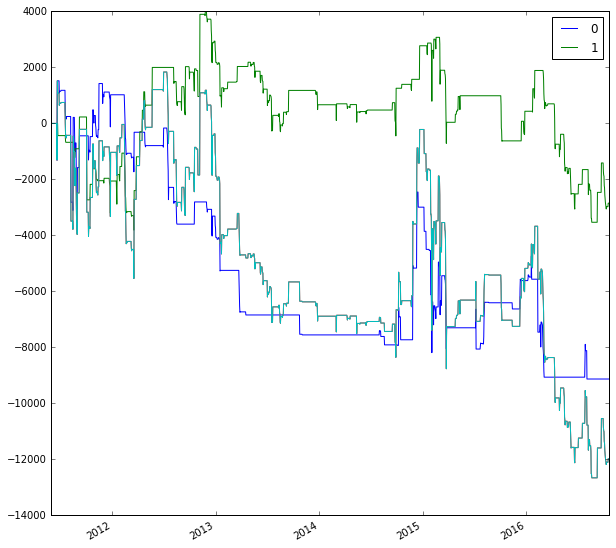

In [19]:
smgr.picked_swarm.plot()

smgr.picked_swarm.sum(1).plot(label='smgr.picked_swarm-sum')
smgr.picked_equity.plot(label='Picked swarm equity')

# Swarm exposure

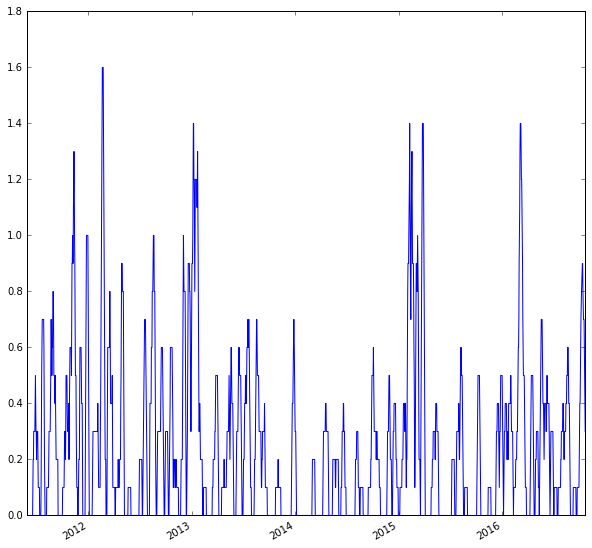

In [22]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [40]:
smgr.picked_stats

{'note:Not implemented yet'}

## Exo information

In [41]:
smgr.strategy.exoinfo.exo_info

{'margin': 0,
 'name': 'CL_BearishCollarBW',
 'pcf': [],
 'pcfqty': [],
 'underlying': ''}

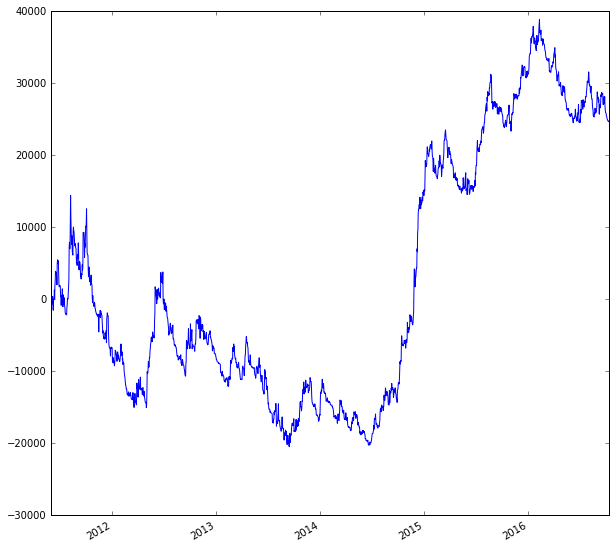

In [42]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

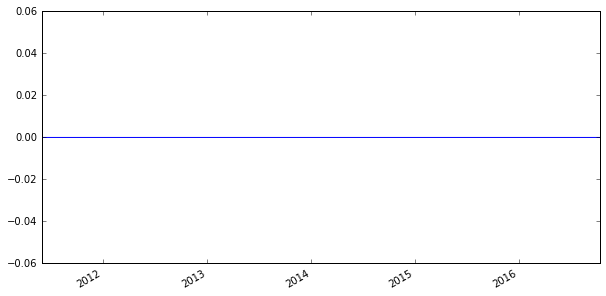

In [43]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

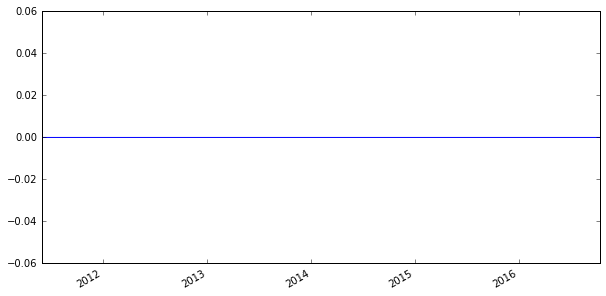

In [44]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [45]:
smgr.save('./swarms/')

In [46]:
smgr.raw_swarm#.plot()

,"(-1, 10, 0)","(-1, 10, 1)","(-1, 110, 0)","(-1, 110, 1)","(-1, 160, 0)","(-1, 160, 1)","(-1, 210, 0)","(-1, 210, 1)","(-1, 260, 0)","(-1, 260, 1)","(-1, 310, 0)","(-1, 310, 1)","(-1, 60, 0)","(-1, 60, 1)"
2011-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
